In [ ]:
# Step 0: Install required libraries in Google Colab
# This makes sure we have all the tools we need
try:
    import tensorflow
except ImportError:
    !pip install tensorflow  # Install TensorFlow for CNN
try:
    import sklearn
except ImportError:
    !pip install scikit-learn  # Install scikit-learn for confusion matrix
try:
    import matplotlib
except ImportError:
    !pip install matplotlib  # Install matplotlib for plotting
try:
    import seaborn
except ImportError:
    !pip install seaborn  # Install seaborn for nice confusion matrix

In [ ]:
# Importing the tools we need
import tensorflow as tf  # For building and training the CNN
import numpy as np  # For handling numbers and arrays
import matplotlib.pyplot as plt  # For making graphs
import seaborn as sns  # For making a nice confusion matrix
from sklearn.metrics import confusion_matrix  # To check how well our model predicts

In [ ]:
# Step 1: Loading the Fashion MNIST dataset
# This dataset is built into TensorFlow, so no need to download or upload anything!
try:
    # Load the dataset (60,000 training images, 10,000 test images)
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    # Define the names of the 10 clothing categories
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    print("Dataset loaded successfully!")
    print(f"Training images: {x_train.shape[0]}")
    print(f"Test images: {x_test.shape[0]}")
    print("Categories:", class_names)
except Exception as e:
    print(f"Error loading dataset: {str(e)}")
    raise

Dataset loaded successfully!
Training images: 60000
Test images: 10000
Categories: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# Step 2: Preprocessing the images
# We need to prepare the images for the CNN
try:
    # Normalize pixel values (0-255 to 0-1) to make training easier
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Reshape images to include a color channel (grayscale = 1 channel)
    # Original shape: (28, 28) → New shape: (28, 28, 1)
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    # Convert labels to one-hot format (e.g., 2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

    print("\nPreprocessing completed successfully!")
    print(f"Training image shape: {x_train.shape}")
    print(f"Test image shape: {x_test.shape}")
except Exception as e:
    print(f"Error in preprocessing: {str(e)}")
    raise

# Step 2.5: Data Augmentation
# Add small random changes to images to help the model learn better
try:
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  # Rotate images slightly
        width_shift_range=0.1,  # Shift images horizontally
        height_shift_range=0.1,  # Shift images vertically
        zoom_range=0.1,  # Zoom in/out slightly
        horizontal_flip=True  # Flip images horizontally
    )
    datagen.fit(x_train)  # Apply augmentation to training data
    print("\nData augmentation set up successfully!")
except Exception as e:
    print(f"Error in data augmentation: {str(e)}")
    raise


Preprocessing completed successfully!
Training image shape: (60000, 28, 28, 1)
Test image shape: (10000, 28, 28, 1)

Data augmentation set up successfully!


In [ ]:
# Step 3: Building the CNN model
# A CNN is like a brain that learns to recognize patterns in images
try:
    model = tf.keras.Sequential([
        # Layer 1: Find simple patterns (like edges) in images
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),  # Stabilize training
        tf.keras.layers.MaxPooling2D(2, 2),  # Shrink image to focus on important parts
        tf.keras.layers.Dropout(0.2),  # Randomly turn off 20% of neurons to prevent overfitting

        # Layer 2: Find more complex patterns
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        # Layer 3: Find even more complex patterns
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        # Flatten the data to feed into regular layers
        tf.keras.layers.Flatten(),

        # Dense layer: Make decisions based on patterns
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        # Output layer: Predict the clothing category (10 categories)
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    print("\nCNN model built successfully!")
except Exception as e:
    print(f"Error building model: {str(e)}")
    raise

# Step 4: Compiling the model
# Tell the model how to learn and measure its performance
try:
    # Define a learning rate scheduler to reduce learning rate over time
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,  # Use Adam with scheduled learning rate
        loss='categorical_crossentropy',  # For multiple categories
        metrics=['accuracy']  # Track how often predictions are correct
    )
    print("\nModel compiled successfully!")
except Exception as e:
    print(f"Error compiling model: {str(e)}")
    raise


CNN model built successfully!

Model compiled successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 5: Training the model
# Let the model learn from the images
try:
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),  # Use augmented data
        epochs=15,  # Train for 15 rounds (more time to learn)
        validation_data=(x_test, y_test),  # Use test data as validation
        verbose=1  # Show progress
    )
    print("\nModel training completed successfully!")
except Exception as e:
    print(f"Error training model: {str(e)}")
    raise

# Step 6: Evaluating the model
# Check how well the model performs on test images
try:
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
except Exception as e:
    print(f"Error evaluating model: {str(e)}")
    raise


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 131s 68ms/step - accuracy: 0.5766 - loss: 1.2407 - val_accuracy: 0.7738 - val_loss: 0.5993
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 112s 60ms/step - accuracy: 0.7380 - loss: 0.7062 - val_accuracy: 0.7977 - val_loss: 0.5265
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 112s 59ms/step - accuracy: 0.7741 - loss: 0.6156 - val_accuracy: 0.8035 - val_loss: 0.5007
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 59ms/step - accuracy: 0.7866 - loss: 0.5801 - val_accuracy: 0.8415 - val_loss: 0.4354
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 114s 61ms/step - accuracy: 0.7964 - loss: 0.5491 - val_accuracy: 0.8488 - val_loss: 0.4069
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 110s 59ms/step - accuracy: 0.8083 - loss: 0.5291 - val_accuracy: 0.8527 - val_loss: 0.3998
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 143s 59ms/step - accuracy: 0.8115 - loss: 0.5108 - val_accuracy: 0.8613 - val_loss: 0.3830
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 141s 59ms/step - accuracy: 0.8189 - lo

In [ ]:
# Step 7: Making predictions
# Use the model to predict categories for test images
try:
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted category
    y_true = np.argmax(y_test, axis=1)  # Get true category
    print("\nPredictions generated successfully!")
except Exception as e:
    print(f"Error making predictions: {str(e)}")
    raise

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

Predictions generated successfully!


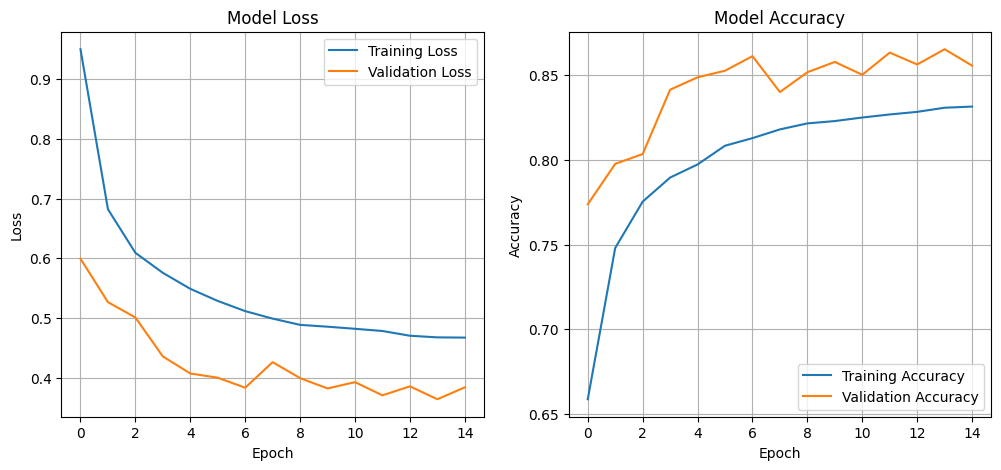


Training metrics plot displayed and saved as 'training_metrics.png'


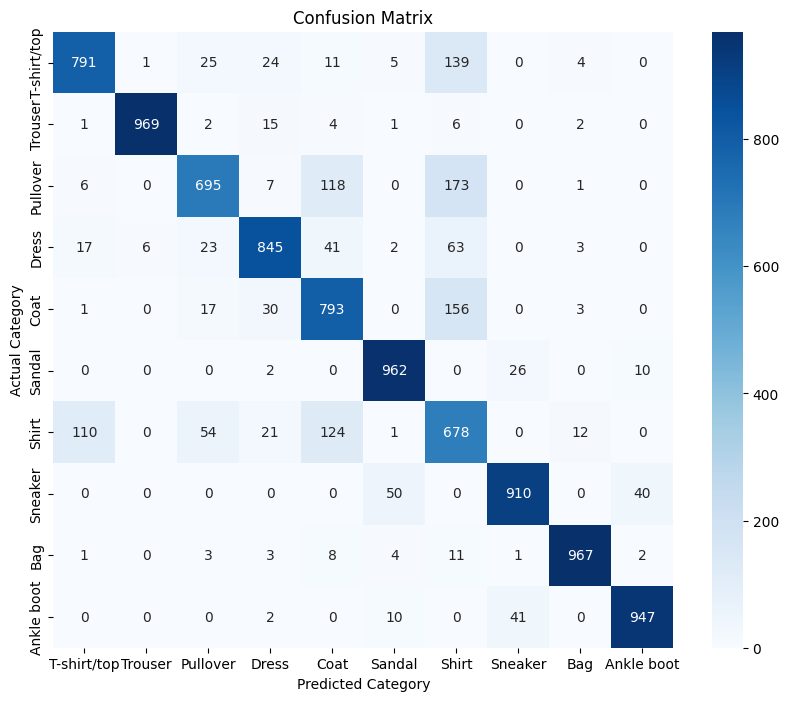

Confusion matrix plot displayed and saved as 'confusion_matrix.png'


In [ ]:
# Step 8: Visualizing the training process
# Show graphs of how the model learned
try:
    plt.figure(figsize=(12, 5))  # Make a wide figure for two graphs

    # Graph 1: Loss (how wrong the model is)
    plt.subplot(1, 2, 1)  # First graph
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')  # Training round
    plt.ylabel('Loss')  # Error amount
    plt.legend()  # Show which line is which
    plt.grid(True)  # Add grid for clarity

    # Graph 2: Accuracy (how often the model is right)
    plt.subplot(1, 2, 2)  # Second graph
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Show the graphs in the notebook
    plt.show()

    # Save the graphs
    plt.savefig('training_metrics.png')
    plt.close()  # Close to free memory
    print("\nTraining metrics plot displayed and saved as 'training_metrics.png'")
except Exception as e:
    print(f"Error visualizing training metrics: {str(e)}")
    raise

# Step 9: Visualizing the confusion matrix
# Show a table of what the model predicted vs. what was correct
try:
    # Make the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))  # Big figure for clarity
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',  # Show numbers in blue
        xticklabels=class_names,  # Category names on x-axis
        yticklabels=class_names  # Category names on y-axis
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Category')
    plt.ylabel('Actual Category')

    # Show the matrix in the notebook
    plt.show()

    # Save the matrix plot
    plt.savefig('confusion_matrix.png')
    plt.close()
    print("Confusion matrix plot displayed and saved as 'confusion_matrix.png'")
except Exception as e:
    print(f"Error visualizing confusion matrix: {str(e)}")
    raise